# DE Portoflio 6: Decision Tree Regressor and Random Forest

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to classify attacks based on relevant features. A regressor model was trained as means of showing ability at applying the method and ensuring this notebook illustrates methods shown in the exercise workbook we were given. However it is important to note that this prediction task requires classification. Hence, the Random Forest model and methods following it are a classifier as it better fits the taks and goal of this exercise.

Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix

### Load and Prepare GTD Data

In [2]:
df=pd.read_csv('Data_All.csv')
display(df)

C:\Users\maria\AppData\Local\Temp\ipykernel_13520\1463796240.py:1: DtypeWarning: Columns (4,31,33,37,54,61,62,63,76,79,90,92,94,96,114,115,121,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data_All.csv')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Electricity
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Other Personnel
214663,202106300030,2021,6,30,NaN,1,2021-07-08,147,Nigeria,11,...,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN,Religious Figure
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN,NaN


#### Features selected
1. region_txt: categorical value for regions where attacks took place
    - For this model we focus on Europe and North America
2. targtype1_txt: (categorical value) explaining the types of targets attacked by the terrorist organisation

3. weaptype1_txt: categorical value for type of weapons sued during the attack

4. property: If a property was attacked during the terrorist incident  (1 = Yes; 0 = No)

5. crit1: binary value explaining whether the attack had a political, social or economic goal (1=Yes; 0=No)

6. crit2: binary value representing whether the attack ahd the intention to coerce or intimidate the public (1=Yes; 0=No)

7. attacktype1_txt: categorical value defining the attack type of the event

8. victims: numerical value representing the number of victims

In [3]:
#Add column with interaction between number of kills and wounded = total number of victims
df['victims_total']=df['nkill']+df['nwound']

In [4]:
#Select relevant features
features=['region_txt', 'crit1', 'crit2',  'attacktype1_txt',
          'targtype1_txt', 'weaptype1_txt', 'victims_total', 'property']
df=df[features]

#Replace unknown, other and -9 values with Nan and remove them
values_to_replace = ['Unknown', 'Other', -9, -99]
df.replace(values_to_replace, np.nan, inplace=True)
df=df.dropna()
copy=df.copy()


In [5]:
#Label attacks
attacks = {'Armed Assault':0, 'Assassination': 1, 'Bombing/Explosion': 2, 'Facility/Infrastructure Attack': 3, 'Hijacking':4, 'Hostage Taking (Barricade Incident)':5, 'Hostage Taking (Kidnapping)':6, 'Unarmed Assault':7}
df['attacktype1_txt'] = df['attacktype1_txt'].replace(attacks)

#Encode target type
target_dummies=pd.get_dummies(df['targtype1_txt'], drop_first=True)
targets = target_dummies.astype(int)

#Encode regions
region_dummies=pd.get_dummies(df['region_txt'], drop_first=True)
region = region_dummies.astype(int)

#Encode weapon type
weapon_dummies=pd.get_dummies(df['weaptype1_txt'], drop_first=True)
weapons=weapon_dummies.astype(int)

#Ensure other variables are numerical
ideology=df['crit1'].astype(int)
property=df['property'].astype(int)
coercion=df['crit2'].astype(int)
victims=df['victims_total'].astype(int)



### Fit Decision Tree Regressor

In [6]:
#Define Y -- outcome variable
Y=df['attacktype1_txt']

#Define X
X= pd.concat([victims, targets, region, property, ideology, coercion, weapons], axis=1)

In [7]:
test_size = 0.30 #Set test size for splitting
random_state = 42 #Set random state to ensure code can be reproduced and results will be unchanged

#Split data into train and test; check shapes to ensure consistency and avoid errors
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (103399, 43), y_train shape: (103399,)
X_test shape: (44315, 43), y_test shape: (44315,)


In [8]:
#Initialize model
regression_tree = DecisionTreeRegressor(max_depth=3)

#Fit regressor
regression_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

#### Generate Predictions and Evaluate Model

In [9]:
#Get predictions
y_pred = regression_tree.predict(X_test)

In [10]:
#Evaluate model by calculating mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.3752544951904375


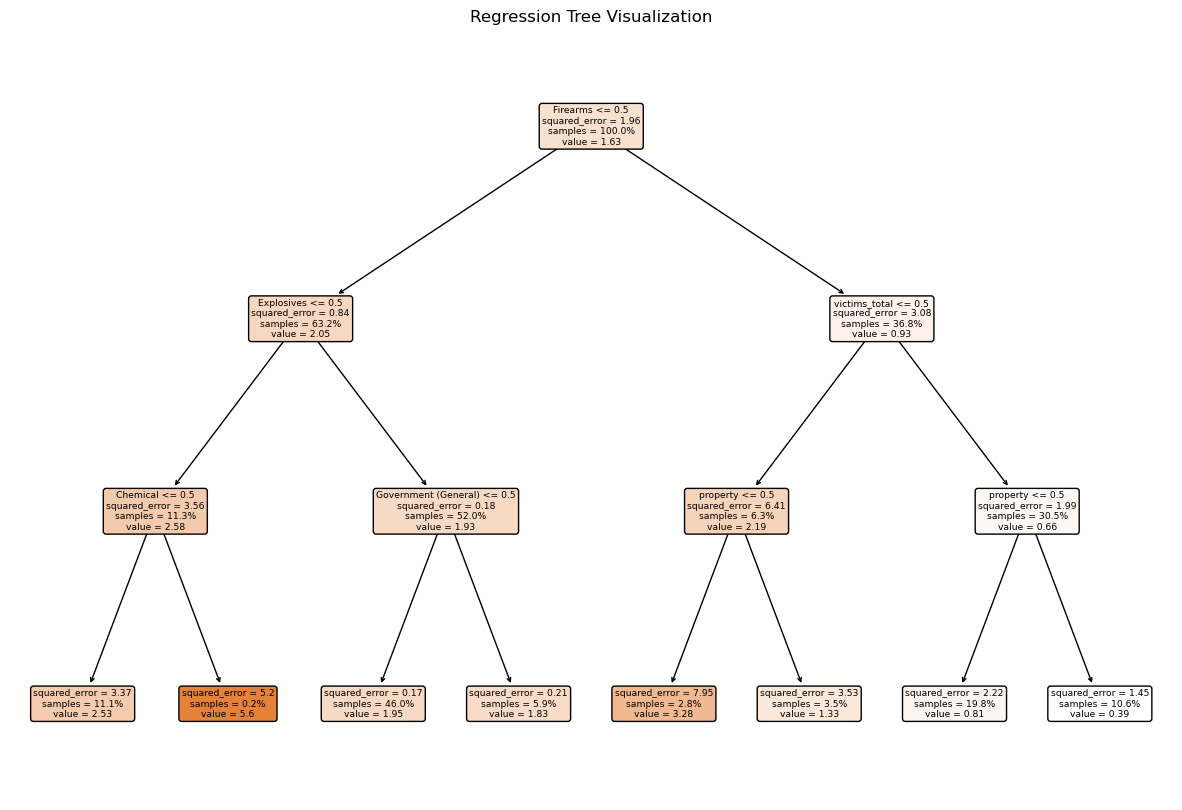

In [11]:
#Plot regression tree
plt.figure(figsize=(15, 10))
plot_tree(regression_tree, feature_names=list(X.columns), filled=True, rounded=True, proportion=True, precision=2)
plt.title("Regression Tree Visualization")
plt.show()

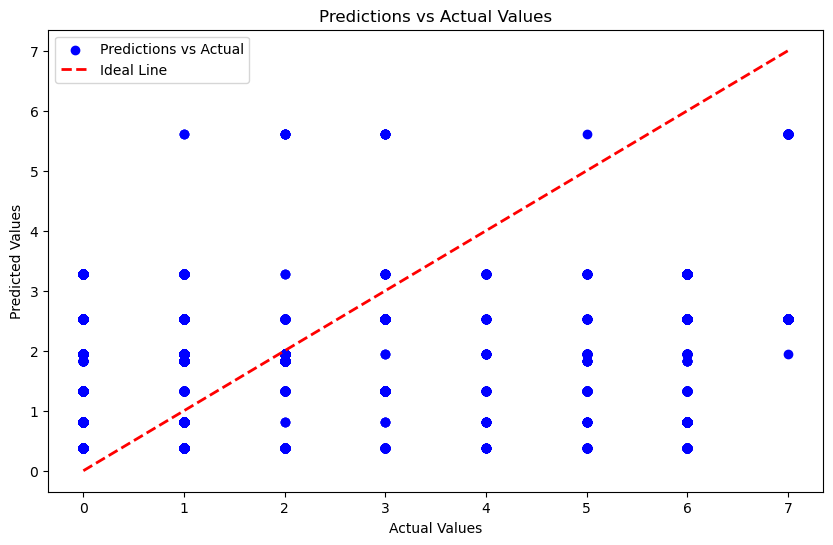

In [12]:
#Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', linewidth=2, label='Ideal Line')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

Looking at how the model made predictions regarding the severity of an attack, it is clear that using a regression model does not fit with the data and outcome we want to predict. This is mainly explained by the fact that most of the features included in the GTD dataset and used in this model are categorical. While a regressor can still be applied to categorical values if encoded, it is not the optimal method as we are not predicting a continous outcome but we are rather predicting how certain attacks will be categorized. Hence, the next part of the notebook replaces the Random Forest Regressor with the Random Forest Classifier to generate more accurate predictions.

### Fit Random Forest Classifier

In [13]:
#Define Y -- outcome variables
Y_rf=df['attacktype1_txt']

#Define X
X_rf= pd.concat([victims, targets, region, property, ideology, coercion, weapons], axis=1)

In [14]:
test_size = 0.30 #Set test size for splitting
random_state = 42 #Set random state

#Split data into test and train set
X_train, X_test, y_train, y_test = train_test_split(X_rf, Y_rf, test_size=test_size, random_state=random_state)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (103399, 43), y_train shape: (103399,)
X_test shape: (44315, 43), y_test shape: (44315,)


In [15]:
#Initialize random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)

#Fit model
random_forest.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### Generate predictions and evaluate model

In [16]:
#Generate predictions
y_pred_rf = random_forest.predict(X_test)

#Evaluate model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy (Random Forest): {accuracy_rf}')

Accuracy (Random Forest): 0.8376170596863365


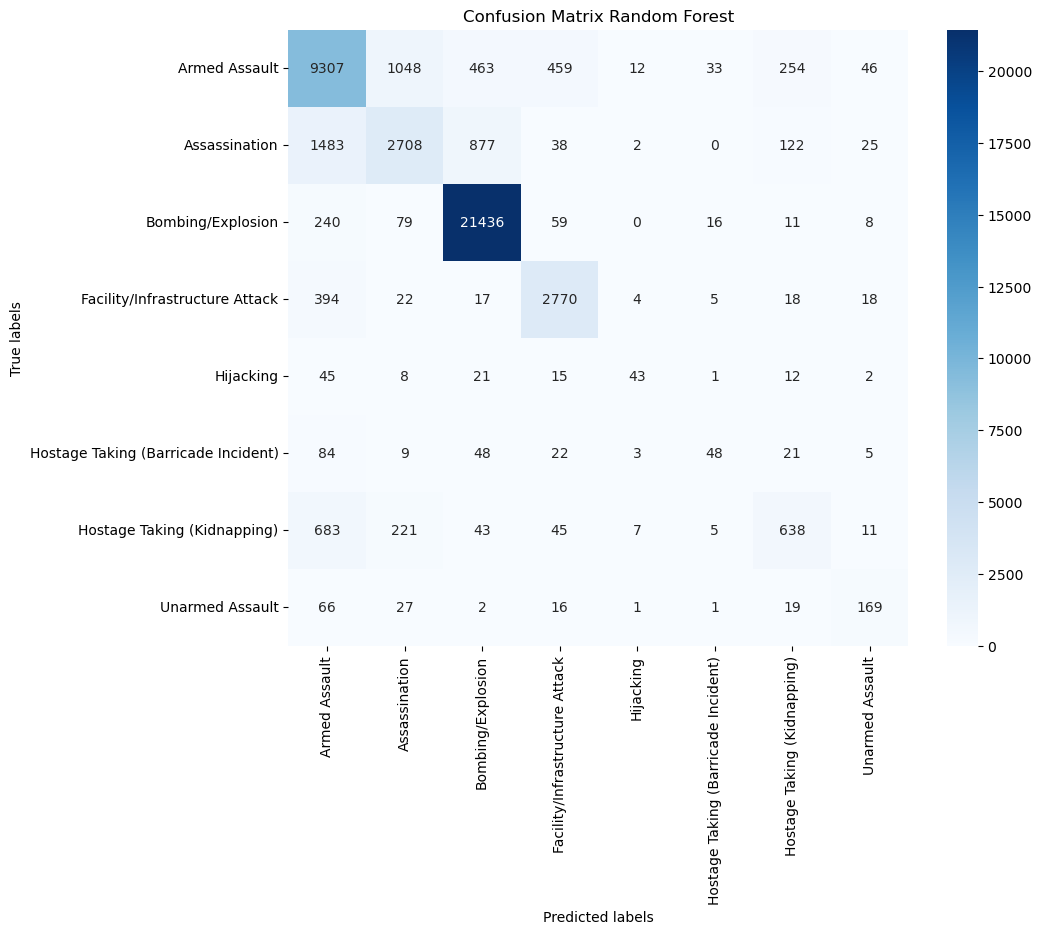

In [17]:
#Calculate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)

#Define labels for matrix
attacks=['Armed Assault', 'Assassination', 'Bombing/Explosion', 'Facility/Infrastructure Attack',  'Hijacking', 'Hostage Taking (Barricade Incident)', 'Hostage Taking (Kidnapping)', 'Unarmed Assault']
df['attacktype1_txt'] = df['attacktype1_txt'].replace(attacks)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=attacks, yticklabels=attacks)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix Random Forest')
plt.show()



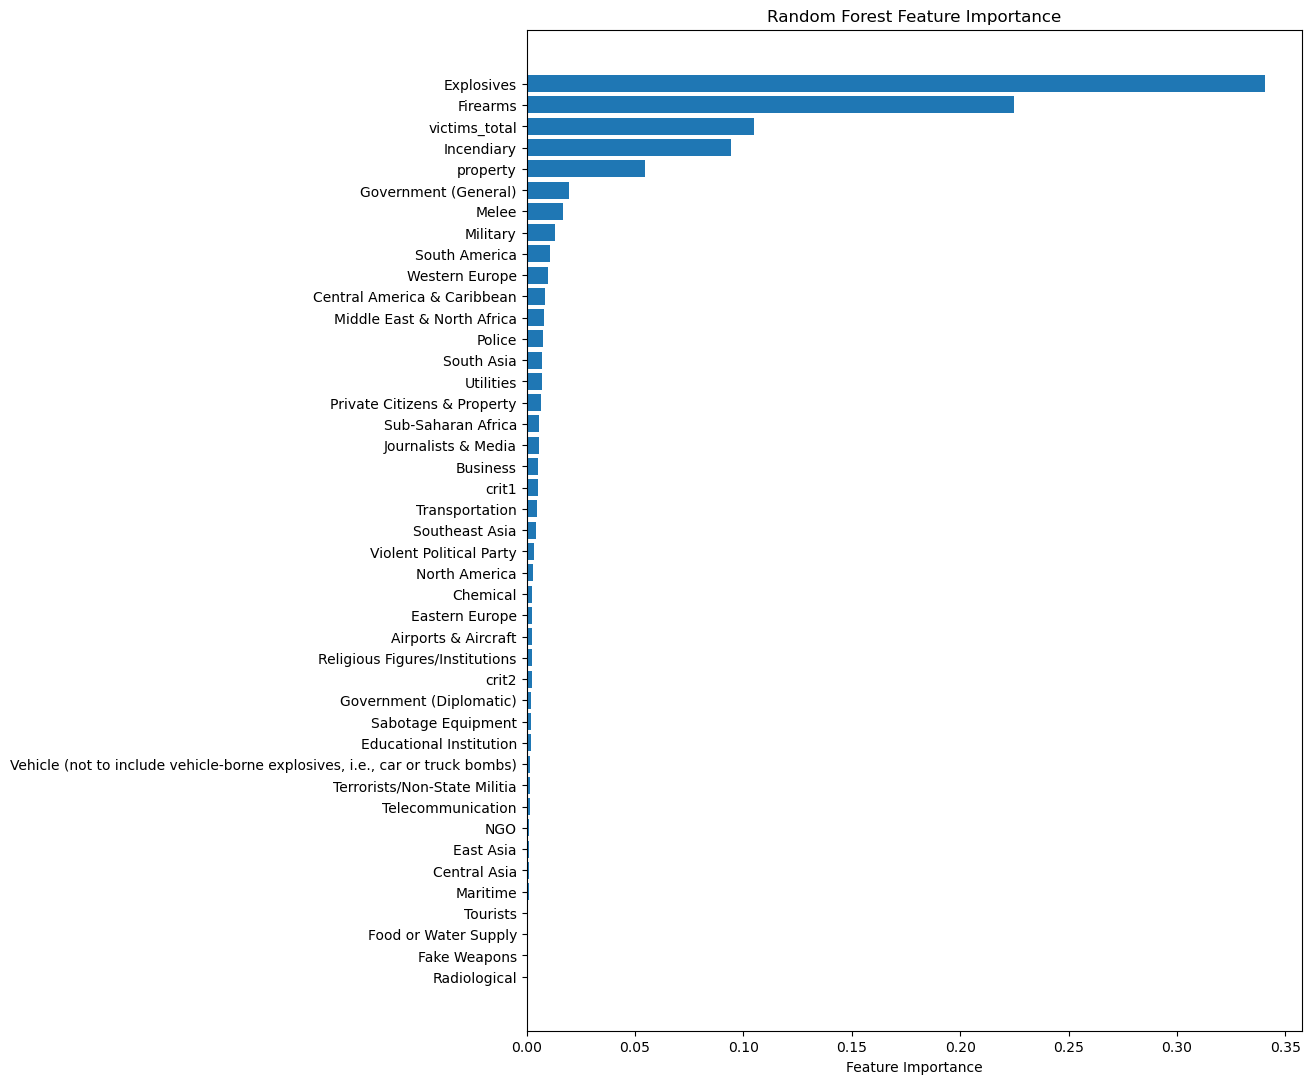

In [18]:
#Look at feature importance to further analyze model
feature_importances = random_forest.feature_importances_

#Get names of features
feature_names = list(X_rf.columns)

#Sort based on importance
sorted_idx = feature_importances.argsort()

# Plot feature importance
plt.figure(figsize=(10, 13))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

In [19]:
#Evaluate model using additional metrics

#Calculate precision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_test, y_pred_rf, average='weighted') #By using a weighted average, 
                                                #we cam account for the imbalance in the dataset

#Calculate recall
recall = recall_score(y_test, y_pred_rf, average='weighted')

#Calculate F1 score
f1 = f1_score(y_test, y_pred_rf, average='weighted')

#Print metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.8271276153057585
Recall: 0.8376170596863365
F1 Score: 0.8297205959004404


### Fit AdaBoost model

In [20]:
#Initialize AdaBoost Classifier
ada = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=42)

#Fit model
ada.fit(X_train, y_train)

#Generate predictions
y_pred_ada = ada.predict(X_test)

#Calculate accuracy
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy (ADABoost): {accuracy_ada}')

Accuracy (ADABoost): 0.799661514159991


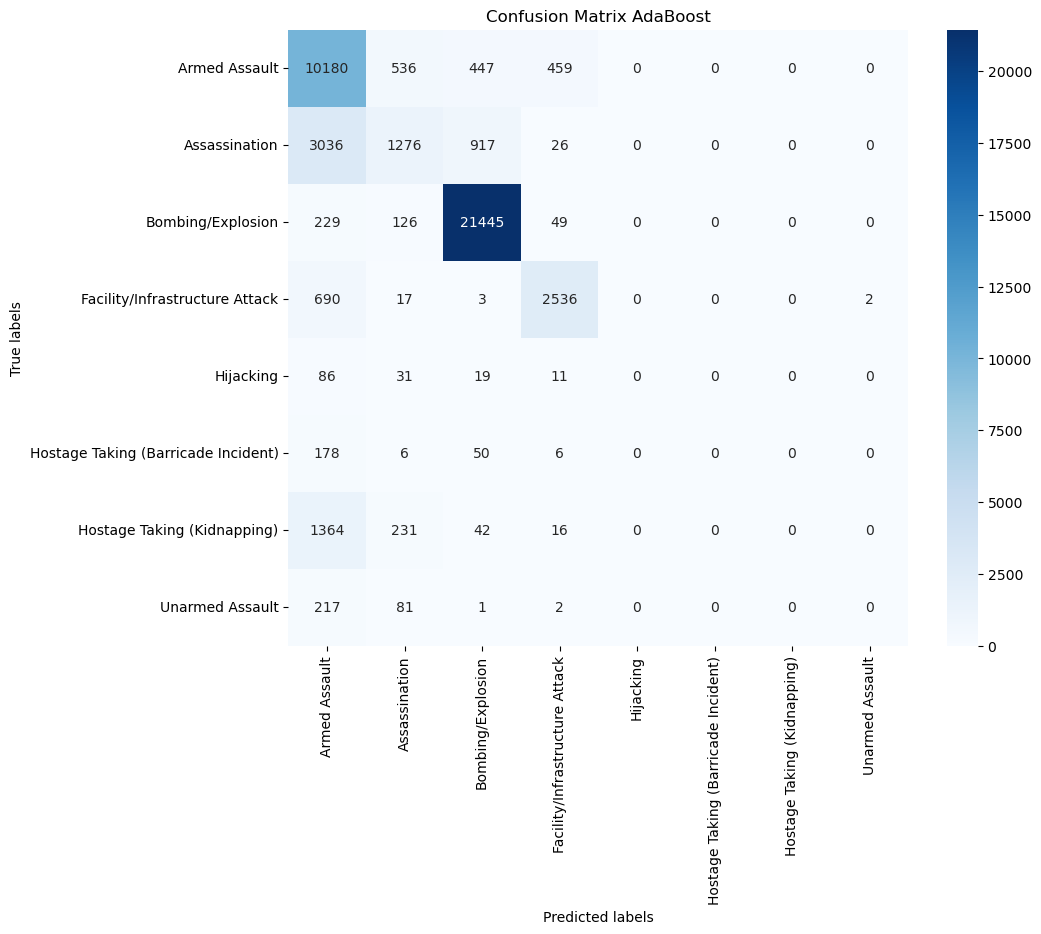

In [21]:
#Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_ada)

#Set lables
attacks=['Armed Assault', 'Assassination', 'Bombing/Explosion', 'Facility/Infrastructure Attack',  'Hijacking', 'Hostage Taking (Barricade Incident)', 'Hostage Taking (Kidnapping)', 'Unarmed Assault']
df['attacktype1_txt'] = df['attacktype1_txt'].replace(attacks)

#Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=attacks, yticklabels=attacks)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix AdaBoost')
plt.show()



### Fit XGB Classifier Model

In [22]:
from xgboost import XGBClassifier

#Initialize model
xgb_model = XGBClassifier(max_depth=3, n_estimators=100, random_state=42)

#Fit model
xgb_model.fit(X_train, y_train)

#Generate predictions
y_pred_xg = xgb_model.predict(X_test)

#Evaluate model
accuracy_xgb = accuracy_score(y_test, y_pred_xg)
print(f'Accuracy (XGBoost): {accuracy_xgb}')

Accuracy (XGBoost): 0.8406859979690849


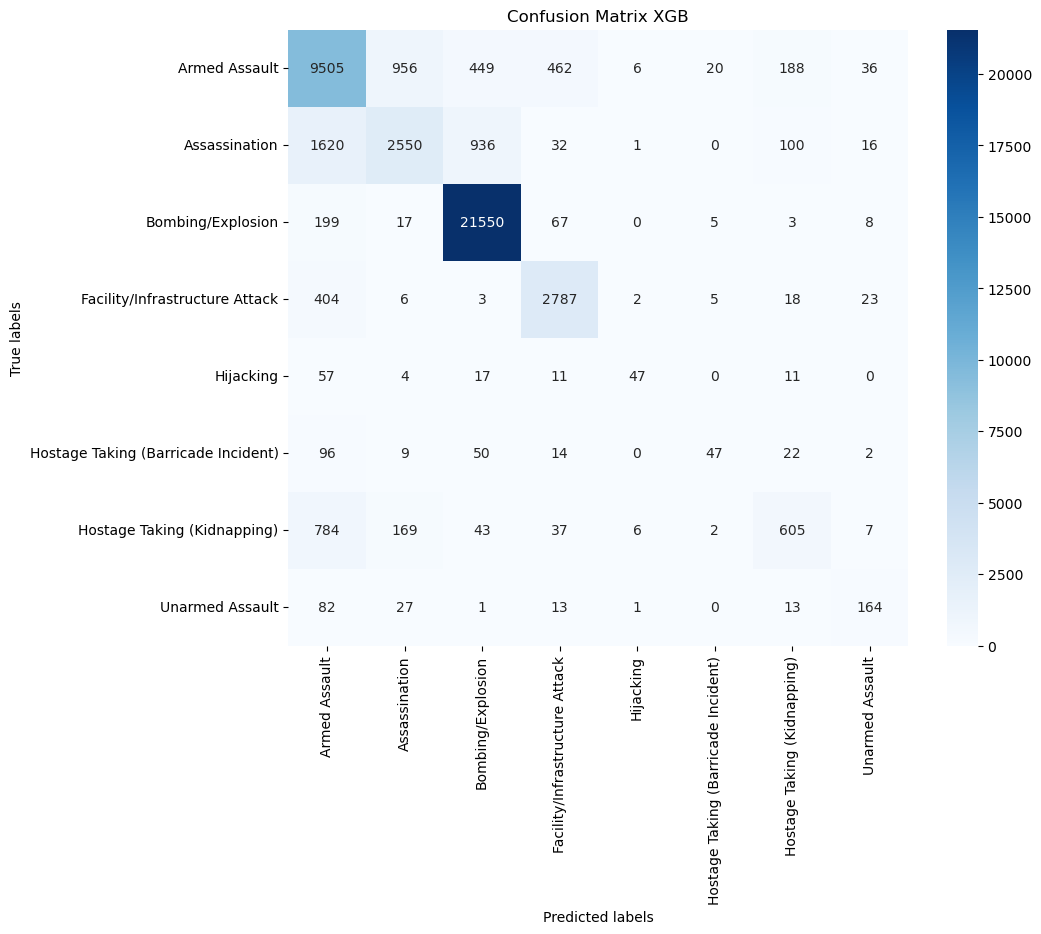

In [23]:
#Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_xg)

#Define labels
attacks=['Armed Assault', 'Assassination', 'Bombing/Explosion', 'Facility/Infrastructure Attack',  'Hijacking', 'Hostage Taking (Barricade Incident)', 'Hostage Taking (Kidnapping)', 'Unarmed Assault']
df['attacktype1_txt'] = df['attacktype1_txt'].replace(attacks)

#Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=attacks, yticklabels=attacks)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix XGB')
plt.show()


##### Interpretation of Notebook
This notebook applies a Decision Tree Regressor and a Random Forest Classifier for a determinisc prediction. As shown by the regression plot, this method is not suitable for this goal. Random Forest, however, was able to successfully predict outcomes and classess of attacks based on the given features. The model had a high accuracy, however the confusion matrix implies there might be some issues because of the dataset imbalances. Boosting methods were also applied, showing that XGBoost can perfrom better than Random Forest or Ada Boost.